In [ ]:
!git clone https://github.com/YeyunLU/Face2Fate

Cloning into 'Face2Fate'...
remote: Enumerating objects: 19958, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 19958 (delta 21), reused 0 (delta 0), pack-reused 19914 (from 1)
Receiving objects: 100% (19958/19958), 200.65 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (2179/2179), done.
Updating files: 100% (78043/78043), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar
!unrar x '/content/drive/My Drive/№11 128 TLTX 08.2023.rar'

In [3]:
import os
import shutil
import random

source_folder = '/content/№11 128 TLTX 08.2023'
train_folder = '/content/train'
test_folder = '/content/test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for class_folder in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_folder)

    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg', '.gif'))]

        random.shuffle(images)

        split_index = int(0.8 * len(images))
        train_images = images[:split_index]
        test_images = images[split_index:]

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_folder + '_' + img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_folder, class_folder + '_' + img))

print("Разделение изображений завершено.")

Разделение изображений завершено.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import atan2, degrees
import pdb
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import cv2
import dlib
import imutils
import os
import csv
from sklearn.preprocessing import LabelEncoder

In [8]:
df = pd.read_csv("/content/combined_labels.csv")
features = ["nose", "mouth", "eye", "eyebrow", "jaw"]

In [9]:
label_encoders = {}

for column in ['nose', 'mouth', 'eye', 'eyebrow', 'jaw']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
print(df)

                          img_file  nose  mouth  eye  eyebrow  jaw
0             1 Дк_-_OnqZ0eJas.jpg     1      1    2        2    2
1                   1 Дк_1200а.jpg     1      1    2        2    0
2                   1 Дк_16028.jpg     1      1    2        2    1
3              1 Дк_16503а (1).jpg     1      1    2        2    1
4              1 Дк_16503а (2).jpg     1      1    2        2    1
...                            ...   ...    ...  ...      ...  ...
69630  99_эльвира болгова (2).jpeg     1      1    2        2    0
69631   99_эльвира болгова (3).jpg     1      1    2        2    0
69632   99_эльвира болгова (5).jpg     1      1    2        2    1
69633   99_эльвира болгова (6).jpg     0      1    0        2    0
69634   99_эльвира болгова (7).jpg     1      1    2        2    1

[69635 rows x 6 columns]


In [41]:
import os

train_path = "/content/train"
test_path = "/content/test"

train_files = {f for f in os.listdir(train_path)}
test_files = {f for f in os.listdir(test_path)}

train_files = {element for i, element in enumerate(train_files) if i <= len(train_files) // 100}
test_files = {element for i, element in enumerate(test_files) if i <= len(test_files) // 100}

train_df = df[df['img_file'].isin(train_files)]
test_df = df[df['img_file'].isin(test_files)]

In [42]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.valid_indices = self.get_valid_indices()

    def get_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.dataframe)):
            img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
            try:
                with Image.open(img_name) as img:
                    img.verify()
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[actual_idx, 0])

        try:
            image = Image.open(img_name).convert('RGB')
            labels = self.dataframe.iloc[actual_idx, 1:].values.astype('long')

            if self.transform:
                image = self.transform(image)

            return image, labels

        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            return None, None

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_df, train_path, transform=transform)
test_dataset = CustomDataset(test_df, test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [43]:
class CNN(nn.Module):
    def __init__(self, num_classes_per_feature):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Подстроить размер
        self.fc2_nose = nn.Linear(512, num_classes_per_feature[0])
        self.fc2_mouth = nn.Linear(512, num_classes_per_feature[1])
        self.fc2_eye = nn.Linear(512, num_classes_per_feature[2])
        self.fc2_eyebrow = nn.Linear(512, num_classes_per_feature[3])
        self.fc2_jaw = nn.Linear(512, num_classes_per_feature[4])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        nose_out = self.fc2_nose(x)
        mouth_out = self.fc2_mouth(x)
        eye_out = self.fc2_eye(x)
        eyebrow_out = self.fc2_eyebrow(x)
        jaw_out = self.fc2_jaw(x)

        return nose_out, mouth_out, eye_out, eyebrow_out, jaw_out

In [44]:
num_classes_per_feature = [len(label_encoders[feature].classes_) for feature in features]
model = CNN(num_classes_per_feature)

In [47]:
from sklearn.metrics import accuracy_score
from PIL import Image
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = [img for img in images if img is not None]
        labels = [lbl for lbl in labels if lbl is not None]
        if len(images) == 0:
          continue

        if len(images) == 0:
            continue

        images = torch.stack(images)
        labels = torch.stack(labels)
        optimizer.zero_grad()

        # Получаем выходы для каждого признака
        nose_out, mouth_out, eye_out, eyebrow_out, jaw_out = model(images)

        loss_nose = criterion(nose_out, labels[:, 0])
        loss_mouth = criterion(mouth_out, labels[:, 1])
        loss_eye = criterion(eye_out, labels[:, 2])
        loss_eyebrow = criterion(eyebrow_out, labels[:, 3])
        loss_jaw = criterion(jaw_out, labels[:, 4])

        loss = loss_nose + loss_mouth + loss_eye + loss_eyebrow + loss_jaw
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели на тестовом наборе
model.eval()
all_labels = []
all_preds_nose = []
all_preds_mouth = []
all_preds_eye = []
all_preds_eyebrow = []
all_preds_jaw = []

with torch.no_grad():
    for images, labels in test_loader:
        nose_out, mouth_out, eye_out, eyebrow_out, jaw_out = model(images)

        _, preds_nose = torch.max(nose_out.data, 1)
        _, preds_mouth = torch.max(mouth_out.data, 1)
        _, preds_eye = torch.max(eye_out.data, 1)
        _, preds_eyebrow = torch.max(eyebrow_out.data, 1)
        _, preds_jaw = torch.max(jaw_out.data, 1)

        all_labels.extend(labels.numpy())
        all_preds_nose.extend(preds_nose.numpy())
        all_preds_mouth.extend(preds_mouth.numpy())
        all_preds_eye.extend(preds_eye.numpy())
        all_preds_eyebrow.extend(preds_eyebrow.numpy())
        all_preds_jaw.extend(preds_jaw.numpy())

# Вычисление метрик для каждого признака (например, точности)
accuracy_nose = accuracy_score([label[0] for label in all_labels], all_preds_nose)
accuracy_mouth = accuracy_score([label[1] for label in all_labels], all_preds_mouth)
accuracy_eye = accuracy_score([label[2] for label in all_labels], all_preds_eye)
accuracy_eyebrow = accuracy_score([label[3] for label in all_labels], all_preds_eyebrow)
accuracy_jaw = accuracy_score([label[4] for label in all_labels], all_preds_jaw)

print(f'Accuracy Nose: {accuracy_nose:.4f}')
print(f'Accuracy Mouth: {accuracy_mouth:.4f}')
print(f'Accuracy Eye: {accuracy_eye:.4f}')
print(f'Accuracy Eyebrow: {accuracy_eyebrow:.4f}')
print(f'Accuracy Jaw: {accuracy_jaw:.4f}')

Epoch [1/10], Loss: 0.1371
Epoch [2/10], Loss: 0.1467
Epoch [3/10], Loss: 0.0763
Epoch [4/10], Loss: 0.1038
Epoch [5/10], Loss: 0.0434
Epoch [6/10], Loss: 0.1174
Epoch [7/10], Loss: 0.0486
Epoch [8/10], Loss: 0.0484
Epoch [9/10], Loss: 0.0849
Epoch [10/10], Loss: 0.0655
Accuracy Nose: 0.8529
Accuracy Mouth: 0.8162
Accuracy Eye: 0.7868
Accuracy Eyebrow: 0.6324
Accuracy Jaw: 0.5809


# Labeling

In [ ]:
facial_features_cordinates = {}

FACIAL_LANDMARKS_INDEXES = OrderedDict([
    ("Mouth", (48, 68)),
    ("Right_Eyebrow", (17, 22)),
    ("Left_Eyebrow", (22, 27)),
    ("Right_Eye", (36, 42)),
    ("Left_Eye", (42, 48)),
    ("Nose", (27, 35)),
    ("Jaw", (0, 17))
])


def shape_to_numpy_array(shape, dtype="int"):
    all_face = np.zeros((68, 2), dtype=dtype)
    mouth_array = np.zeros((20, 2), dtype=dtype)
    eye_array = np.zeros((12, 2), dtype=dtype)
    eyebrow_array = np.zeros((10, 2), dtype=dtype)
    nose_arry = np.zeros((9, 2), dtype=dtype)
    jaw_array = np.zeros((17, 2), dtype=dtype)
    data = {}

    for i in range(0, 68):
        all_face[i] = (shape.part(i).x, shape.part(i).y)

    jaw_array = all_face[:17, :]
    eyebrow_array = all_face[17:27, :]
    nose_array = all_face[27:36, :]
    eye_array = all_face[36:48, :]
    mouth_array = all_face[48:, :]
    jaw_list = jaw_array[:, 0].tolist()
    jaw_list.extend(jaw_array[:, 1].tolist())
    nose_list = nose_array[:, 0].tolist()
    nose_list.extend(nose_array[:, 1].tolist())
    eyebrow_list = eyebrow_array[:, 0].tolist()
    eyebrow_list.extend(eyebrow_array[:, 1].tolist())
    eye_list = eye_array[:, 0].tolist()
    eye_list.extend(eye_array[:, 1].tolist())
    mouth_list = mouth_array[:, 0].tolist()
    mouth_list.extend(mouth_array[:,1].tolist())

    data["jaw"] = jaw_list
    data["nose"] = nose_list
    data["eyebrow"] =  eyebrow_list
    data["eye"] = eye_list
    data["mouth"] = mouth_list
    return data


def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
    overlay = image.copy()
    output = image.copy()

    if colors is None:
        colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                  (168, 100, 168), (158, 163, 32),
                  (163, 38, 32), (180, 42, 220)]

    for (i, name) in enumerate(FACIAL_LANDMARKS_INDEXES.keys()):
        (j, k) = FACIAL_LANDMARKS_INDEXES[name]
        pts = shape[j:k]
        facial_features_cordinates[name] = pts

        if name == "Jaw":
            for l in range(1, len(pts)):
                ptA = tuple(pts[l - 1])
                ptB = tuple(pts[l])
                cv2.line(overlay, ptA, ptB, colors[i], 2)
        else:
            hull = cv2.convexHull(pts)
            cv2.drawContours(overlay, [hull], -1, colors[i], -1)

    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    print(facial_features_cordinates)
    return output

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("Face2Fate/src/demo/data/shape_predictor_68_face_landmarks.dat")

ROOT_DIR = os.path.abspath(os.curdir)
image_folder = os.path.join("/content/train")
image_folder2 = os.path.join("/content/test")
jaw = []
nose =[]
eye = []
eyebrow =[]
mouth = []
idx = 0
for img in os.listdir(image_folder):
    print(idx)
    idx+=1
    image_path = os.path.join(image_folder,img)
    image = cv2.imread(image_path)
    if image is None:
      continue
    image = imutils.resize(image, width=500)
    if image is None:
      continue
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)

        all_face = shape_to_numpy_array(shape)
        all_face["jaw"].insert(0, img)
        all_face["eye"].insert(0, img)
        all_face["mouth"].insert(0, img)
        all_face["eyebrow"].insert(0, img)
        all_face["nose"].insert(0, img)
        jaw.append(all_face["jaw"])
        eye.append(all_face["eye"])
        mouth.append(all_face["mouth"])
        eyebrow.append(all_face["eyebrow"])
        nose.append(all_face["nose"])

for img in os.listdir(image_folder2):
    print(idx)
    idx+=1
    image_path = os.path.join(image_folder2,img)
    image = cv2.imread(image_path)
    if image is None:
      continue
    image = imutils.resize(image, width=500)
    if image is None:
      continue
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        all_face = shape_to_numpy_array(shape)
        all_face["jaw"].insert(0, img)
        all_face["eye"].insert(0, img)
        all_face["mouth"].insert(0, img)
        all_face["eyebrow"].insert(0, img)
        all_face["nose"].insert(0, img)
        jaw.append(all_face["jaw"])
        eye.append(all_face["eye"])
        mouth.append(all_face["mouth"])
        eyebrow.append(all_face["eyebrow"])
        nose.append(all_face["nose"])

list = [eyebrow, eye, nose, mouth, jaw]
names = ["eyebrow", "eye", "nose", "mouth", "jaw"]
for i in range(len(list)):
    file_name = names[i]+".csv"
    with open(file_name,'w', encoding='utf8',newline='') as f:
        writer = csv.writer(f)
        writer.writerows(list[i])

# Eye



In [ ]:
x = []
y = []
origin = []
with open('eye.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        origin.append(row[0])
        data = [int(d) for d in row[1:]]
        n = int(len(data)/2)
        x.append(data[:n])
        y.append(data[n:])
num = len(x)
print("data num:",num)

data num: 66365


In [ ]:
def cal_angle(x, y):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    d1 = degrees(atan2(dy,dx))
    dx = x[1]-x[2]
    dy = y[1]-y[2]
    d2 = degrees(atan2(dy,dx))
    return d1+d2

In [ ]:
angles1 = []
angles2 = []
labels = []
dys = []
dxs = []
big = 0
silt = 0
small = 0
for i in range(num):
    rx = x[i]
    ry = y[i]
    dy = (ry[4]+ry[5]-ry[1]-ry[2])/2
    dx = rx[3]-rx[0]
    dxs.append(dx)
    dys.append(dy)
    if dy>23:
        labels.append("big")
        big+=1
    elif dx>70:
        labels.append("silt")
        silt+=1
    else:
        labels.append("small")
        small+=1

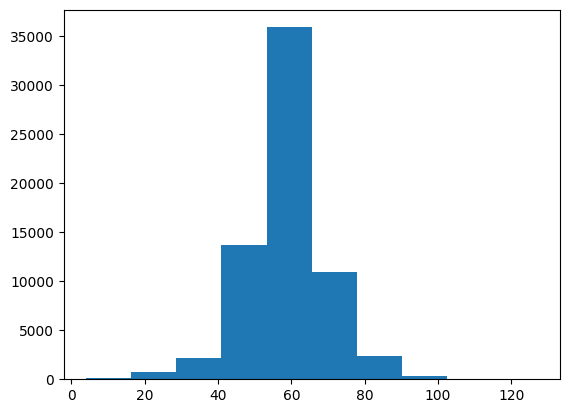

In [ ]:
plt.hist(dxs, bins=10)
plt.show()

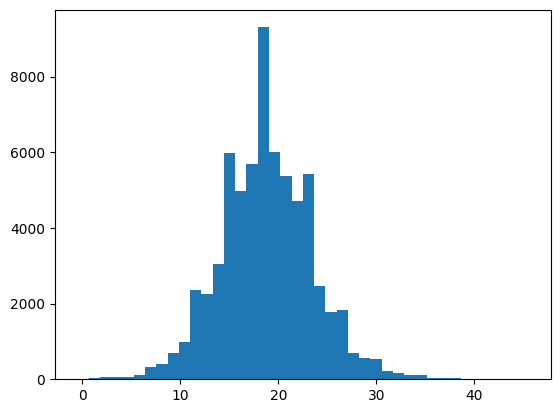

In [ ]:
plt.hist(dys, bins=40)
plt.show()

In [ ]:
labels = np.asarray(labels).reshape((num,1))
origin = np.asarray(origin).reshape((num,1))
output = np.hstack((origin,labels))

In [ ]:
with open('eye_labels.csv','w',encoding='utf8',newline='') as file:
    wr = csv.writer(file)
    wr.writerow(['img_file', 'eye'])
    wr.writerows(output)

# Eyebrow

In [ ]:
x = []
y = []
origin = []
with open("eyebrow.csv") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        origin.append(row[0])
        data = [int(d) for d in row[1:]]
        n = int(len(data)/2)
        x.append(data[:n])
        y.append(data[n:])
num = len(x)
print("data num:",num)

data num: 66365


In [ ]:
def cal_angle(x, y):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    d1 = degrees(atan2(dy,dx))
    dx = x[1]-x[2]
    dy = y[1]-y[2]
    d2 = degrees(atan2(dy,dx))
    return abs(d1-d2)

In [ ]:
angles1 = []
angles2 = []
labels = []
dists=[]
for i in range(num):
    rx = x[i]
    ry = y[i]
    dists.append(rx[5]-rx[4])
    angle1 = cal_angle(rx[0:3],ry[0:3])
    angles1.append(angle1)
    angle2 = cal_angle(rx[1:4],ry[1:4])
    angles2.append(angle2)
    if angle1<175:
        labels.append("Arch")
    elif angle2<180:
        labels.append("Straight")
    else:
        labels.append("Circle")

In [ ]:
labels = np.asarray(labels).reshape((num,1))
origin = np.asarray(origin).reshape((num,1))
output = np.hstack((origin,labels))

In [ ]:
with open('eyebrow_labels.csv','w',encoding='utf8',newline='') as file:
    wr = csv.writer(file)
    wr.writerow(['img_file', 'eyebrow'])
    wr.writerows(output)

#Jaw

In [ ]:
x = []
y = []
origin = []
with open('jaw.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        origin.append(row[0])
        data = [int(d) for d in row[1:]]
        n = int(len(data)/2)
        x.append(data[:n])
        y.append(data[n:])
num = len(x)
print("data num:",num)

data num: 66365


In [ ]:
def cal_curve(x, y):
    gx = np.gradient(x) # first derivatives
    gy = np.gradient(y)
    g2x = np.gradient(gx) #second derivatives
    g2y = np.gradient(gy)
    cur = np.abs(g2y) / np.power((np.sqrt(1 + np.power(gy,2))),1.5)
    cur = -np.sort(-cur)
    return cur[:2]

In [ ]:
def cal_angle(x, y):
    degree = []
    dx = x[8] - x[4]
    dy = y[8] - y[4]
    degree = degrees(atan2(dy,dx))*2
    return degree

In [ ]:
angles = []
curs1 = []
curs2 = []
labels = []
dys = []
dxs = []
square = 0
oval = 0
circle = 0
triangle = 0
for i in range(num):
    rx = x[i]
    ry = y[i]
    cur1, cur2 = cal_curve(rx,ry)
    angle = cal_angle(rx,ry)
    curs1.append(cur1)
    curs2.append(cur2)
    angles.append(angle)
    if cur2 > 0.5:
        labels.append("square")
        square += 1
    elif cur1 > 15:
        labels.append("triangle")
        triangle += 1
    elif angle > 80:
        labels.append("circle")
        circle += 1
    else:
        labels.append("oval")
        oval += 1

In [ ]:
labels = np.asarray(labels).reshape((num,1))
origin = np.asarray(origin).reshape((num,1))
output = np.hstack((origin,labels))

In [ ]:
with open('jaw_labels.csv','w',encoding='utf8',newline='') as file:
    wr = csv.writer(file)
    wr.writerow(['img_file', 'jaw'])
    wr.writerows(output)

# Mouth

In [ ]:
x = []
y = []
origin = []
with open('mouth.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        origin.append(row[0])
        data = [int(d) for d in row[1:]]
        n = int(len(data)/2)
        x.append(data[:n])
        y.append(data[n:])
num = len(x)
print("data num:",num)

data num: 66365


In [ ]:
def cal_angle(x, y):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    d1 = degrees(atan2(dy,dx))
    dx = x[1]-x[2]
    dy = y[1]-y[2]
    d2 = degrees(atan2(dy,dx))
    return d1+d2

In [ ]:
labels = []
dxs = []
tops = []
bottoms = []
thick = 0
medium = 0
small = 0
for i in range(num):
    rx = x[i]
    ry = y[i]
    top = ry[14]-ry[3]
    bottom = ry[9]-ry[18]
    total = top + bottom
    dx = max(rx)-min(rx)
    dxs.append(dx)
    tops.append(top)
    bottoms.append(bottom)
    if dx < 150:
        labels.append("small")
        small += 1
    elif top > 10 and bottom > 30:
        labels.append("thick")
        thick +=1
    else:
        labels.append("medium")
        medium += 1

In [ ]:
labels = np.asarray(labels).reshape((num,1))
origin = np.asarray(origin).reshape((num,1))
output = np.hstack((origin,labels))

In [ ]:
with open('mouth_labels.csv','w',encoding='utf8',newline='') as file:
    wr = csv.writer(file)
    wr.writerow(['img_file', 'mouth'])
    wr.writerows(output)

# Nose

In [ ]:
x = []
y = []
origin = []
with open('nose.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        origin.append(row[0])
        data = [int(d) for d in row[1:]]
        n = int(len(data)/2)
        x.append(data[:n])
        y.append(data[n:])
num = len(x)
print("data num:",num)

data num: 66365


In [ ]:
def cal_angle(x, y):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    d1 = degrees(atan2(dy,dx))
    dx = x[1]-x[2]
    dy = y[1]-y[2]
    d2 = degrees(atan2(dy,dx))
    return d1+d2

In [ ]:
angles1 = []
angles2 = []
labels = []
dys = []
dxs = []
wide = 0
long = 0
small = 0
for i in range(num):
    rx = x[i]
    ry = y[i]
    dy = ry[6]-ry[0]
    dx = rx[8]-rx[4]
    dxs.append(dx)
    dys.append(dy)
    if dy < 140:
        labels.append("small")
        small +=1
    elif dx > 90:
        labels.append("wide")
        wide+=1
    else:
        labels.append("long")
        long+=1

In [ ]:
labels = np.asarray(labels).reshape((num,1))
origin = np.asarray(origin).reshape((num,1))
output = np.hstack((origin,labels))

In [ ]:
with open('nose_labels.csv','w',encoding='utf8',newline='') as file:
    wr = csv.writer(file)
    wr.writerow(['img_file', 'nose'])
    wr.writerows(output)

In [ ]:
file_paths = [
    'nose_labels.csv',
    'mouth_labels.csv',
    'eye_labels.csv',
    'eyebrow_labels.csv',
    'jaw_labels.csv'
]

combined_df = None

for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        print(f"Столбцы в {file_path}: {df.columns.tolist()}")

        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on='img_file', how='outer')

    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {e}")

if combined_df is not None:
    combined_df.to_csv('combined_labels.csv', index=False)
else:
    print("Нет данных для объединения.")

Столбцы в nose_labels.csv: ['img_file', 'nose']
Столбцы в mouth_labels.csv: ['img_file', 'mouth']
Столбцы в eye_labels.csv: ['img_file', 'eye']
Столбцы в eyebrow_labels.csv: ['img_file', 'eyebrow']
Столбцы в jaw_labels.csv: ['img_file', 'jaw']


In [ ]:
combined_df

,img_file,nose,mouth,eye,eyebrow,jaw
0,1 Дк_-_OnqZ0eJas.jpg,small,small,small,Straight,square
1,1 Дк_1200а.jpg,small,small,small,Straight,circle
2,1 Дк_16028.jpg,small,small,small,Straight,oval
3,1 Дк_16503а (1).jpg,small,small,small,Straight,oval
4,1 Дк_16503а (2).jpg,small,small,small,Straight,oval
...,...,...,...,...,...,...
69630,99_эльвира болгова (2).jpeg,small,small,small,Straight,circle
69631,99_эльвира болгова (3).jpg,small,small,small,Straight,circle
69632,99_эльвира болгова (5).jpg,small,small,small,Straight,oval
69633,99_эльвира болгова (6).jpg,long,small,big,Straight,circle


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('combined_labels.csv')

image_paths = df['img_file'].values
labels = df['label'].values

unique_labels = np.unique(labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_index[label] for label in labels])

X_train, X_test, y_train, y_test = train_test_split(image_paths, numeric_labels, test_size=0.2, random_state=42)

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    return img_array

train_images = np.array([load_and_preprocess_image(img_path) for img_path in X_train])
test_images = np.array([load_and_preprocess_image(img_path) for img_path in X_test])

y_train_categorical = to_categorical(y_train, num_classes=len(unique_labels))
y_test_categorical = to_categorical(y_test, num_classes=len(unique_labels))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(test_images, y_test_categorical)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

csv_file = '/content/.csv'
data = pd.read_csv(csv_file)

label_encoders = {}
for column in ['nose', 'mouth', 'eye', 'eyebrow', 'jaw']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

images = []
for img_file in data['img_file']:
    img_path = f'path/to/your/images/{img_file}'
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)
    images.append(img_array)

images = np.array(images) / 255.0

X_train, X_val, y_train, y_val = train_test_split(images, data[['nose', 'mouth', 'eye', 'eyebrow', 'jaw']], test_size=0.2, random_state=42)